In [ ]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.4)
!pip install visualkeras
import visualkeras
# Miscellaneous
from tqdm import tqdm
import os
import random

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 17.4 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = r'/content/drive/MyDrive/MRI dataset/Training'
test_dir = '/content/drive/MyDrive/MRI dataset/Testing'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+"//" +label):
        train_paths.append(train_dir + '//'+label+ '//'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

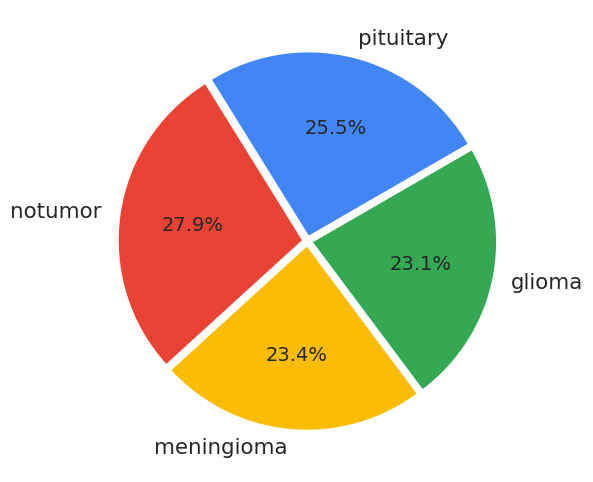

In [ ]:

plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in train_labels if x=='pituitary']),
         len([x for x in train_labels if x=='notumor']),
         len([x for x in train_labels if x=='meningioma']),
         len([x for x in train_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);

In [ ]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+ '//' + label):
        test_paths.append(test_dir +'//'+label + '//'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

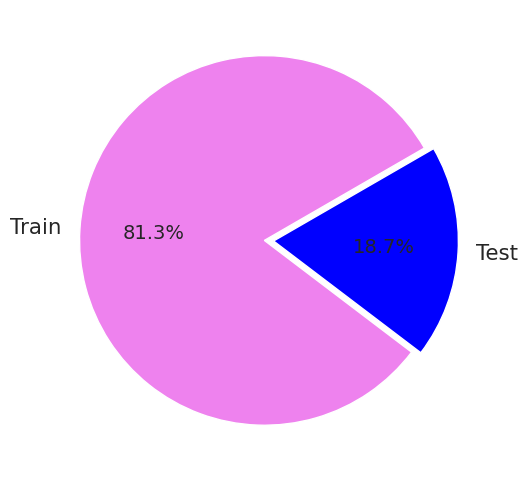

In [ ]:
plt.figure(figsize=(14,6))
colors = ['Violet' , 'Blue']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);


In [ ]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Sharpness(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

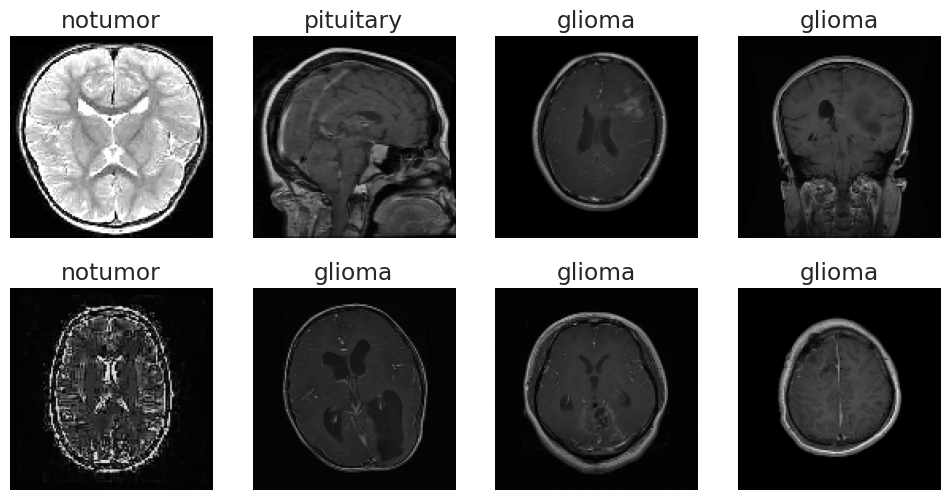

In [ ]:
IMAGE_SIZE = 128


def open_images(paths):

    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)


images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()


In [ ]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [ ]:
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 25088)             0

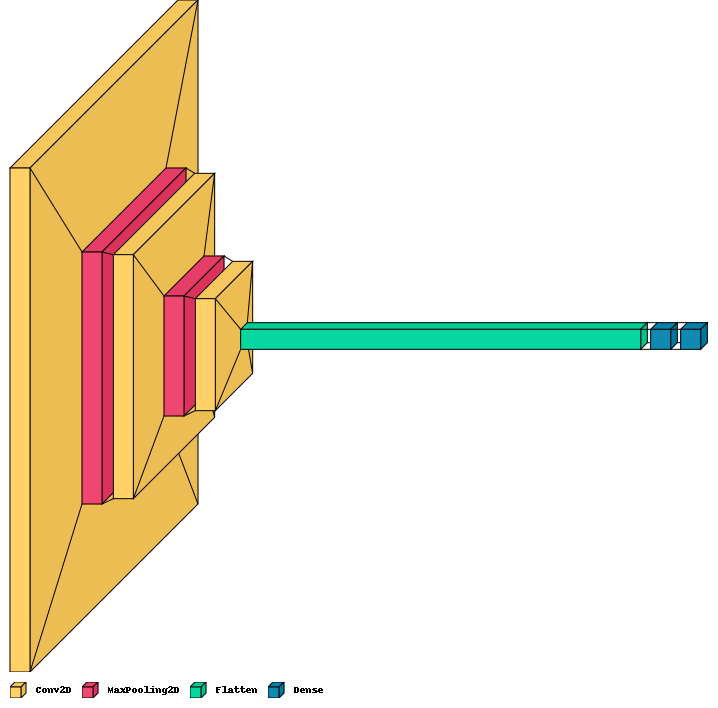

In [ ]:
visualkeras.layered_view(model,legend=True)

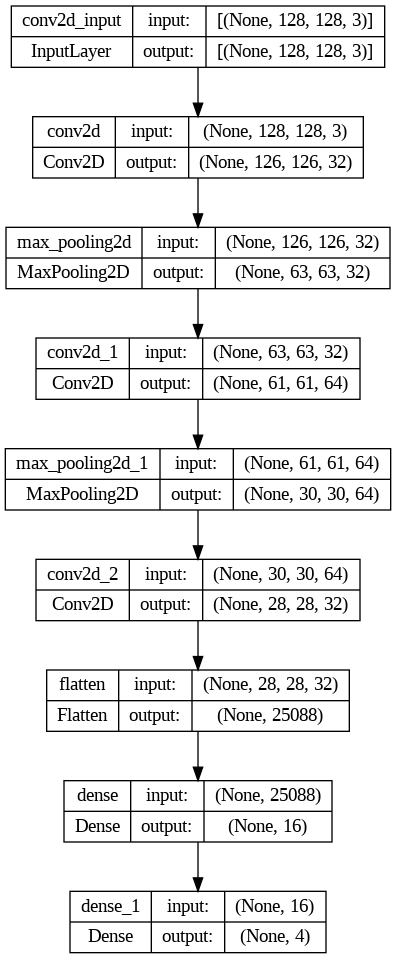

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [ ]:
batch_size = 32
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
178/178 [==============================] - 41s 231ms/step - loss: 0.2192 - sparse_categorical_accuracy: 0.9221
Epoch 2/10
178/178 [==============================] - 29s 164ms/step - loss: 0.1922 - sparse_categorical_accuracy: 0.9342
Epoch 3/10
178/178 [==============================] - 41s 230ms/step - loss: 0.1794 - sparse_categorical_accuracy: 0.9359
Epoch 4/10
178/178 [==============================] - 29s 165ms/step - loss: 0.1565 - sparse_categorical_accuracy: 0.9426
Epoch 5/10
178/178 [==============================] - 30s 167ms/step - loss: 0.1459 - sparse_categorical_accuracy: 0.9482
Epoch 6/10
178/178 [==============================] - 32s 177ms/step - loss: 0.1326 - sparse_categorical_accuracy: 0.9523
Epoch 7/10
178/178 [==============================] - 29s 164ms/step - loss: 0.1178 - sparse_categorical_accuracy: 0.9599
Epoch 8/10
178/178 [==============================] - 29s 163ms/step - loss: 0.1121 - sparse_categorical_accuracy: 0.9625
Epoch 9/10
178/178 [====

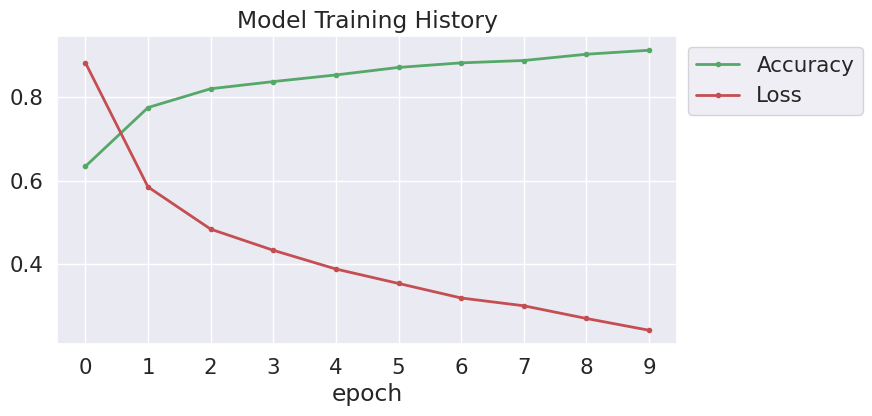

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
train_loss, train_acc = model.evaluate(open_images(train_paths), encode_label(train_labels))
test_loss, test_acc = model.evaluate(open_images(test_paths), encode_label(test_labels))

print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)

41/41 [==============================] - 1s 12ms/step - loss: 0.3385 - sparse_categorical_accuracy: 0.8734
Train accuracy: 0.9275209903717041
Test accuracy: 0.873379111289978


In [ ]:
predictions = model.predict(open_images(test_paths))
predictions = np.argmax(predictions, axis=1)
print(classification_report(encode_label(test_labels), predictions, target_names=unique_labels))



41/41 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

   pituitary       0.93      0.96      0.94       300
     notumor       0.93      0.97      0.95       405
  meningioma       0.74      0.79      0.77       306
      glioma       0.89      0.75      0.81       300

    accuracy                           0.88      1311
   macro avg       0.87      0.87      0.87      1311
weighted avg       0.88      0.88      0.88      1311



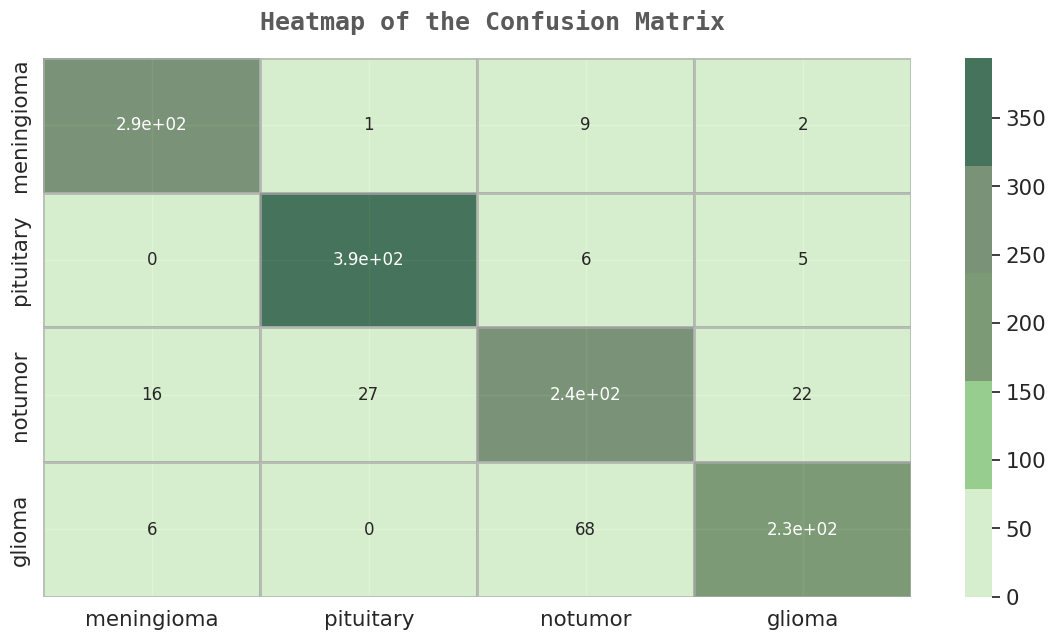

In [ ]:
labels = ['meningioma','pituitary','notumor','glioma']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(encode_label(test_labels),predictions),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [ ]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model2 = Sequential()
model2.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model2.add(base_model)
model2.add(Flatten())
model2.add(Dropout(0.3))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(len(unique_labels), activation='softmax'))

58889256/58889256 [==============================] - 0s 0us/step


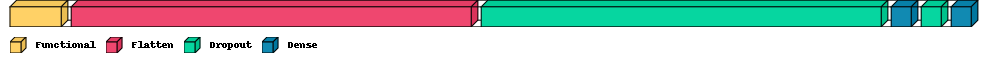

In [ ]:
visualkeras.layered_view(model2,legend=True)

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15,763,908
Trainable params: 8,128,644
N

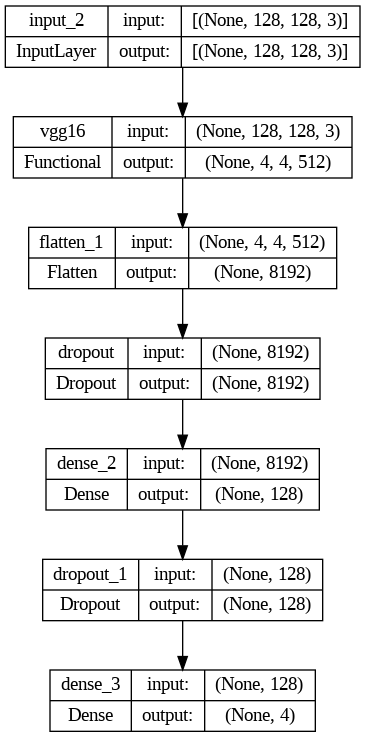

In [ ]:
keras.utils.plot_model(model2, show_shapes=True)

In [ ]:
model2.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [ ]:
batch_size = 32
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model2.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
178/178 [==============================] - 34s 170ms/step - loss: 0.4473 - sparse_categorical_accuracy: 0.8276
Epoch 2/10
178/178 [==============================] - 31s 168ms/step - loss: 0.2371 - sparse_categorical_accuracy: 0.9125
Epoch 3/10
178/178 [==============================] - 30s 169ms/step - loss: 0.1417 - sparse_categorical_accuracy: 0.9479
Epoch 4/10
178/178 [==============================] - 31s 173ms/step - loss: 0.1086 - sparse_categorical_accuracy: 0.9595
Epoch 5/10
178/178 [==============================] - 30s 169ms/step - loss: 0.0810 - sparse_categorical_accuracy: 0.9708
Epoch 6/10
178/178 [==============================] - 30s 168ms/step - loss: 0.0702 - sparse_categorical_accuracy: 0.9724
Epoch 7/10
178/178 [==============================] - 30s 170ms/step - loss: 0.0613 - sparse_categorical_accuracy: 0.9789
Epoch 8/10
178/178 [==============================] - 30s 169ms/step - loss: 0.0332 - sparse_categorical_accuracy: 0.9880
Epoch 9/10
178/178 [====

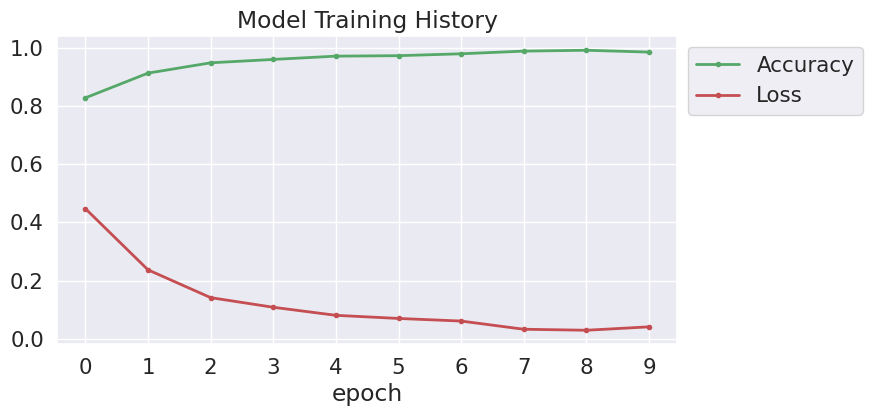

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model2.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 139ms/step


  2%|▎         | 1/40 [00:00<00:13,  2.81it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 2/40 [00:00<00:10,  3.46it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 3/40 [00:00<00:09,  3.81it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 4/40 [00:01<00:08,  4.01it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▎        | 5/40 [00:01<00:08,  4.15it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 6/40 [00:01<00:07,  4.26it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 7/40 [00:01<00:07,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 8/40 [00:01<00:07,  4.28it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▎       | 9/40 [00:02<00:07,  4.35it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 10/40 [00:02<00:06,  4.31it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 11/40 [00:02<00:06,  4.36it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 12/40 [00:02<00:06,  4.42it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▎      | 13/40 [00:03<00:06,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 14/40 [00:03<00:06,  4.31it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 15/40 [00:03<00:05,  4.38it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 16/40 [00:03<00:05,  4.35it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▎     | 17/40 [00:04<00:05,  4.34it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 18/40 [00:04<00:05,  4.30it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 19/40 [00:04<00:04,  4.33it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 20/40 [00:04<00:04,  4.33it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▎    | 21/40 [00:04<00:04,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 22/40 [00:05<00:04,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▊    | 23/40 [00:05<00:03,  4.39it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 24/40 [00:05<00:03,  4.39it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▎   | 25/40 [00:05<00:03,  4.35it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 26/40 [00:06<00:03,  4.35it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 27/40 [00:06<00:03,  3.95it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 28/40 [00:06<00:03,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▎  | 29/40 [00:06<00:02,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 30/40 [00:07<00:02,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 31/40 [00:07<00:02,  3.46it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 32/40 [00:07<00:02,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▎ | 33/40 [00:08<00:02,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 34/40 [00:08<00:01,  3.35it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 35/40 [00:08<00:01,  3.32it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 36/40 [00:09<00:01,  3.50it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▎| 37/40 [00:09<00:00,  3.67it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 38/40 [00:09<00:00,  3.83it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 39/40 [00:09<00:00,  3.94it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 40/40 [00:10<00:00,  4.03it/s]

1/1 [==============================] - 2s 2s/step


41it [00:12,  3.40it/s]


In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.95      0.94      0.94       300
  meningioma       0.91      0.96      0.94       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      0.95      0.97       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.97      0.96      0.97      1311



In [ ]:
# build inception model
base_model = InceptionV3(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True
base_model.layers[-5].trainable = True

model3 = Sequential()
model3.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model3.add(base_model)
model3.add(Flatten())
model3.add(Dropout(0.3))
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(len(unique_labels), activation='softmax'))

model3.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_2 (Dropout)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                       

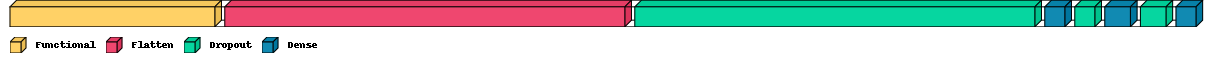

In [ ]:
visualkeras.layered_view(model3,legend=True)

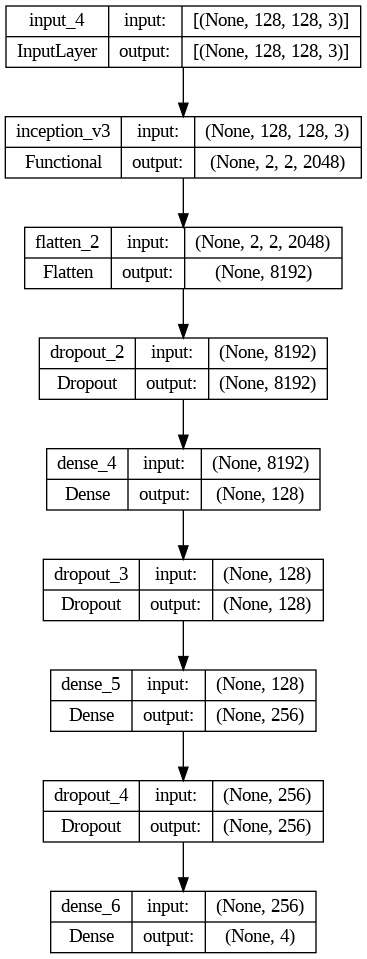

In [ ]:
keras.utils.plot_model(model3, show_shapes=True)

In [ ]:
model3.compile(optimizer=Adam(learning_rate=0.0001),
                loss='sparse_categorical_crossentropy',
                metrics=['sparse_categorical_accuracy'])



In [ ]:
batch_size = 32
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model3.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
178/178 [==============================] - 36s 165ms/step - loss: 0.8934 - sparse_categorical_accuracy: 0.6534
Epoch 2/10
178/178 [==============================] - 30s 164ms/step - loss: 0.5629 - sparse_categorical_accuracy: 0.7877
Epoch 3/10
178/178 [==============================] - 30s 170ms/step - loss: 0.4690 - sparse_categorical_accuracy: 0.8231
Epoch 4/10
178/178 [==============================] - 30s 169ms/step - loss: 0.4230 - sparse_categorical_accuracy: 0.8421
Epoch 5/10
178/178 [==============================] - 30s 169ms/step - loss: 0.3737 - sparse_categorical_accuracy: 0.8576
Epoch 6/10
178/178 [==============================] - 30s 170ms/step - loss: 0.3428 - sparse_categorical_accuracy: 0.8701
Epoch 7/10
178/178 [==============================] - 29s 165ms/step - loss: 0.3126 - sparse_categorical_accuracy: 0.8803
Epoch 8/10
178/178 [==============================] - 29s 166ms/step - loss: 0.2811 - sparse_categorical_accuracy: 0.8991
Epoch 9/10
178/178 [====

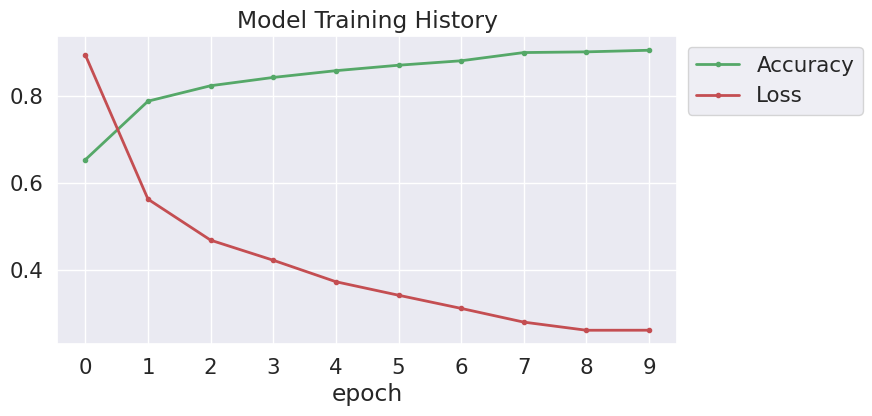

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
# Evaluate model with test data
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model3.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


  2%|▎         | 1/40 [00:01<00:52,  1.35s/it]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 2/40 [00:01<00:26,  1.46it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 3/40 [00:01<00:17,  2.09it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 4/40 [00:02<00:13,  2.61it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▎        | 5/40 [00:02<00:11,  3.05it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 6/40 [00:02<00:09,  3.43it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 7/40 [00:02<00:08,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 8/40 [00:02<00:08,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▎       | 9/40 [00:03<00:07,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 10/40 [00:03<00:07,  3.95it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 11/40 [00:03<00:06,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 12/40 [00:03<00:06,  4.31it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▎      | 13/40 [00:04<00:06,  4.29it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 14/40 [00:04<00:06,  4.25it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 15/40 [00:04<00:05,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 16/40 [00:04<00:05,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▎     | 17/40 [00:05<00:05,  4.26it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 18/40 [00:05<00:05,  4.15it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 19/40 [00:05<00:04,  4.27it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 20/40 [00:05<00:04,  4.39it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▎    | 21/40 [00:05<00:04,  4.48it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 22/40 [00:06<00:03,  4.55it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▊    | 23/40 [00:06<00:03,  4.58it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 24/40 [00:06<00:03,  4.54it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▎   | 25/40 [00:06<00:03,  4.53it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 26/40 [00:07<00:03,  4.51it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 27/40 [00:07<00:02,  4.53it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 28/40 [00:07<00:02,  4.58it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▎  | 29/40 [00:07<00:02,  4.51it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 30/40 [00:07<00:02,  4.43it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 31/40 [00:08<00:02,  4.44it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 32/40 [00:08<00:01,  4.53it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▎ | 33/40 [00:08<00:01,  4.41it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 34/40 [00:08<00:01,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 35/40 [00:09<00:01,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 36/40 [00:09<00:00,  4.44it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▎| 37/40 [00:09<00:00,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 38/40 [00:09<00:00,  4.35it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 39/40 [00:10<00:00,  4.16it/s]

1/1 [==============================] - 0s 41ms/step


100%|██████████| 40/40 [00:10<00:00,  3.88it/s]

1/1 [==============================] - 3s 3s/step


41it [00:13,  3.07it/s]


In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.90      0.85      0.87       300
  meningioma       0.83      0.82      0.82       306
     notumor       0.93      0.98      0.96       405
   pituitary       0.94      0.92      0.93       300

    accuracy                           0.90      1311
   macro avg       0.90      0.89      0.90      1311
weighted avg       0.90      0.90      0.90      1311



In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
path='/content/drive/MyDrive/MRI dataset/Testing/meningioma/Te-meTr_0003.jpg'

my_image = load_img(path, target_size=(128, 128))

#preprocess the image
my_image = img_to_array(my_image)
my_image = my_image/255
my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
#my_image = preprocess_input(my_image)
print(unique_labels,'\n')
#make the prediction
prediction = model2.predict(my_image)
print(prediction,'\n')
predict_index = np.argmax(prediction)
if(predict_index==1):
    print("There is no tumor")
    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img = mpimg.imread(path)
    imgplot = plt.imshow(img)
    plt.show()
else:
    print("There is a tumor")

['pituitary', 'notumor', 'meningioma', 'glioma'] 

1/1 [==============================] - 0s 74ms/step
[[1.865426e-04 2.684300e-04 1.699568e-02 9.825494e-01]] 

There is a tumor


The tumor is: GLIOMA


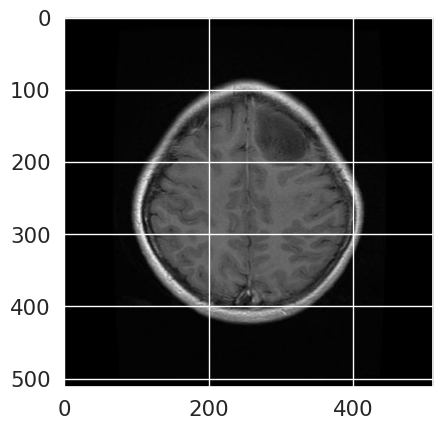

In [ ]:
if(predict_index!=1):
    if(predict_index==0):
        print("The tumor is: PITUITARY")
    elif(predict_index==2):
        print("The tumor is: MENINGIOMA")
    else:
        if(predict_index==3):
            print("The tumor is: GLIOMA")
        
    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img = mpimg.imread(path)
    imgplot = plt.imshow(img)
    plt.show()
    